In [2]:
import numpy as np
import matplotlib.pyplot as plt
import bayer
from itertools import product

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
bayer.get_pattern_tile([[1, 0], [0, 1]], (5,5))*1

array([[1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1]])

# Маски

Прототип (финальные версии см. в bayer.py)

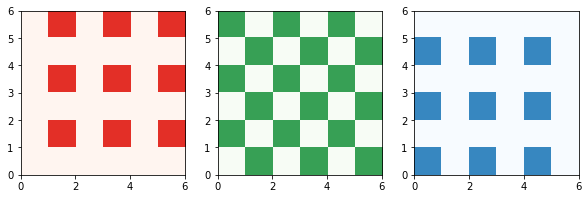

In [118]:
n_rows = 6
n_cols = 6

red_tile = np.array([[0, 1], [0, 0]], dtype=bool)
green_tile = np.eye(2, dtype=bool)
blue_tile = np.array([[0, 0], [1, 0]], dtype=bool)
red = np.tile(red_tile, (n_rows // 2 + n_rows % 2, n_cols // 2 + n_cols % 2))
green = np.tile(green_tile, (n_rows // 2 + n_rows % 2, n_cols // 2 + n_cols % 2))
blue = np.tile(blue_tile, (n_rows // 2 + n_rows % 2, n_cols // 2 + n_cols % 2))
if n_rows % 2:
    red = red[:-1, :]
    green = green[:-1, :]
    blue = blue[:-1, :]
if n_cols % 2:
    red = red[:, :-1]
    green = green[:, :-1]
    blue = blue[:, :-1]

f, axs = plt.subplots(1, 3, figsize=(10,10))
axs[0].imshow(red, cmap='Reds', vmax=1.5, origin='upper', extent=[0,n_cols,0,n_rows])
axs[1].imshow(green, cmap='Greens', vmax=1.5, origin='upper', extent=[0,n_cols,0,n_rows])
axs[2].imshow(blue, cmap='Blues', vmax=1.5, origin='upper', extent=[0,n_cols,0,n_rows])
plt.show()

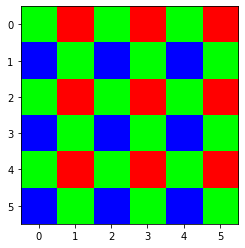

In [119]:
mask = np.dstack((red, green, blue))
plt.imshow(mask.astype(np.uint8)*255)

# Цветное изображение с неизвестными значениями

In [156]:
raw_img = np.array([[5,1,3],[2,0,6],[7,8,9]])
bayer.get_colored_img(raw_img)

array([[[0, 5, 0],
        [1, 0, 0],
        [0, 3, 0]],

       [[0, 0, 2],
        [0, 0, 0],
        [0, 0, 6]],

       [[0, 7, 0],
        [8, 0, 0],
        [0, 9, 0]]])

# Билинейная интерполяция

 Медленное решение

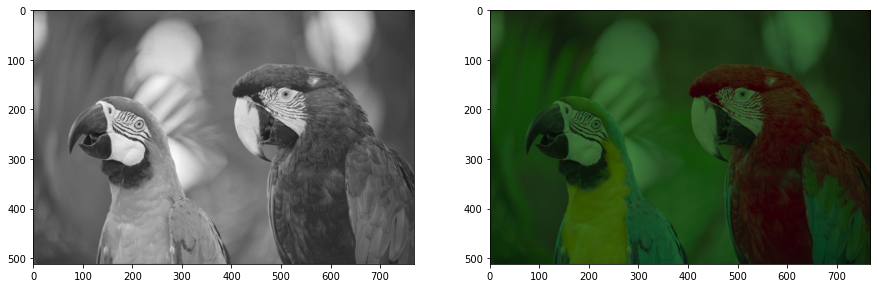

In [518]:
from skimage.io import imread
parrots_img = imread('tests\\04_unittest_bilinear_img_input\\09.png')
parrots_colored = bayer.get_colored_img(parrots_img)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(parrots_img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(parrots_colored)

In [253]:
raw_img = np.array([[202, 150, 137, 121, 195],
                         [ 94, 113, 217,  68, 248],
                         [208, 170, 109,  67,  22],
                         [ 20,  93, 222,  54,  50],
                         [254, 252,  10, 187, 203]], dtype='uint8')

In [438]:
img = bayer.get_colored_img(raw_img)
new_img = np.copy(img)
masks = bayer.get_bayer_masks(*img.shape[:-1]) 
for channel in range(3):
    mask = masks[:, :, channel]
    reduced_img = img[:, :, channel]
    for i, j in product(range(1, img.shape[0] - 1), range(1, img.shape[1] - 1)):
        if mask[i, j]:
            continue
        area = np.nonzero(mask[i-1:i+2, j-1:j+2])
        new_img[i, j, channel] = np.mean(reduced_img[i - 1 + area[0], j - 1 + area[1]])

Очень быстрое решение

In [305]:
from scipy.ndimage import convolve

In [449]:
test = bayer.get_colored_img(raw_img)
blue_2 = bayer.get_pattern_tile([[1,0],[0,1]], test.shape[:-1])
blue_4 = bayer.get_pattern_tile([[0,0],[1,0]], test.shape[:-1])
green = bayer.get_pattern_tile([[0,1],[1,0]], test.shape[:-1])
red_2 = blue_2
red_4 = bayer.get_pattern_tile([[0,1],[0,0]], test.shape[:-1])

convolved_2_blue = convolve(test[:, :, 0], np.ones((3,3)) / 2)
convolved_2_red = convolve(test[:, :, 2], np.ones((3,3)) / 2)
convolved_4_blue = convolve(test[:, :, 0], np.ones((3,3)) / 4)
convolved_4_red = convolve(test[:, :, 2], np.ones((3,3)) / 4)
convolved_green = convolve(test[:, :, 1], np.ones((3,3)) / 4)

convolved_2_blue[~blue_2] = 0
convolved_2_red[~red_2] = 0
convolved_4_blue[~blue_4] = 0
convolved_4_red[~red_4] = 0
convolved_green[~green] = 0


test[:, :, 0] += convolved_2_blue + convolved_4_blue
test[:, :, 1] += convolved_green
test[:, :, 2] += convolved_2_red + convolved_4_red

In [454]:
(new_img[1:4,1:4,0] == test[1:4,1:4,0]).all()

True

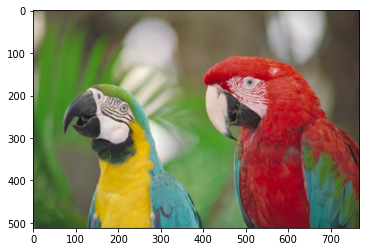

In [493]:
plt.imshow(bayer.bilinear_interpolation(parrots_colored))

# Улучшенная линейная интерполяция

In [623]:
res = bayer.improved_interpolation(parrots_img)

Green mask assertion:
True
Red mask assertion:
True
Blue mask assertion:
True


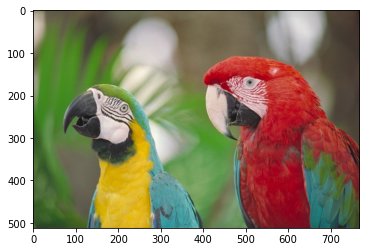

In [625]:
plt.imshow(res)

# PSNR

In [628]:
res1 = bayer.bilinear_interpolation(parrots_colored)
res2 = bayer.improved_interpolation(parrots_img)

In [674]:
bayer.compute_psnr(res1, res2)

10.413766115809754